# TabStruct: Structural Deep Encoding Methods – Overview Notebook

This notebook provides an interactive overview of the core architectural components and encoding strategies introduced in our paper: **"TabStruct: Structural Deep Encoding for Table-to-Text Generation"**.

We demonstrate key mechanisms used in our models, including:
- Special Token Injection
- Structural Embeddings (Row, Column)
- Attention Masking (Structured Attention)
- Bias Matrices (Relational Biases)
- Position Embeddings: CPE/TPE (Column/Token Position Embeddings)

📄 **Paper:** [ACL 2025](https://arxiv.org/pdf/2503.01457)  
📦 **Repo:** [GitHub - TabStruct](https://github.com/RaphaelMouravieff/TabStruct)  
📊 **Data Release:** See [Releases](https://github.com/RaphaelMouravieff/TabStruct/releases)

> ⚠️ This notebook is for educational/demo purposes and reproduces small-scale behavior of encoding modules.

In [43]:
import os
import sys
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, os.path.abspath('..'))

from transformers import BartTokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')


# Structural encoding modules and utilities
from tabstruct.attention.bias_utils import get_relative_relation_ids
from transformers.models.tapas.modeling_tapas import IndexMap, ProductIndexMap, reduce_min, gather
from tabstruct.attention.masking_utils import generate_mask
from tabstruct.data_modules.T0_preprocessing import preprocess_tableqa_function_T0
from tabstruct.data_modules.T1_preprocessing import preprocess_tableqa_function_T1
from tabstruct.data_modules.T2_preprocessing import preprocess_tableqa_function_T2
from transformers.models.bart.modeling_bart import _prepare_4d_attention_mask

def create_heatmap(matrix, labels, title=None, save=False):
    """
    Function to create a heatmap from a given matrix and labels for both axes.

    Args:
    - matrix (torch.Tensor or np.ndarray): 2D matrix for heatmap values.
    - labels (list or np.ndarray): Labels for both x and y axes (assumed to be the same).
    """
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.squeeze().numpy()  # Convert to numpy if tensor
    
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='viridis', aspect='auto')

    # Adding labels and title
    #plt.colorbar(label='Value')
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90)
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.xlabel('Encoded')
    plt.ylabel('Encoded')
    plt.title('Heatmap of Matrix Values' if title is None else title)

    # Ensuring the grid aligns with heatmap cells
    ax = plt.gca()  # Get current axes
    ax.set_xticks(np.arange(matrix.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(matrix.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', size=0)  # Hide minor tick marks

    # Display the heatmap
    plt.tight_layout()
    if save and title is not None:
        path = f"Notebooks/{title}.pdf"
        #plt.savefig(path)

        plt.savefig(path, dpi=300, transparent=True, format='pdf')
        print(f'figure save at : {path}')
    plt.show()

class DataArgs():
    max_source_length= 38
    max_target_length= 11
    ignore_pad_token_for_loss=False
    is_wtq=False
    show_tokenization=True
    training_type= "debug"

class ModelArgs():
    model_name_or_path= "facebook/bart-base"
    config_name= "microsoft/tapex-base"
    tokenizer_name= "facebook/bart-base"
    cache_dir= None
    model_revision= "main"
    use_auth_token= type=bool, False
    encoding_type= "T2_M3_TPE_B0_E1"
    mask_query_table= 0
    is_inference= True



class TrainingArgs():
    per_device_train_batch_size= 1
    gradient_accumulation_steps= 1
    resume_from_checkpoint= None

data_args = DataArgs
model_args = ModelArgs
training_args = TrainingArgs

def gen_example():
    table = {"header":["c_1","c2","c3"],
            "rows" : [["Name", "Alice", "Bob"],
                    ["Age", "25", "30"]]}
    query = "what ?"
    anwsers = "25"
    example = {"table":[table], "question":[query], "answers":[anwsers]}
    return example
example = gen_example()

## 🧩 Special Tokens

Insert special structural tokens (e.g., <col>, <row>, <cell>) into the input sequence to explicitly mark table elements.\
These tokens help the model recognize and attend to the tabular layout more effectively.\
🔍 Related Work: [TAPEX](https://arxiv.org/abs/2107.07653)

In [ ]:
# T0
model_inputs = preprocess_tableqa_function_T0(example, tokenizer, data_args, "max_length", None, is_training=False)
pd.DataFrame([a + [b] for a,b in  zip(model_inputs['token_type'][0], [tokenizer.decode(i) for i in model_inputs["input_ids"][0]])],
              columns= ["Segment", "Col ID", "Row ID", "Tokens"])

,Segment,Col ID,Row ID,Tokens
0,0,0,0,<s>
1,0,0,0,what
2,0,0,0,?
3,1,1,0,c
4,1,1,0,_
5,1,1,0,1
6,1,2,0,c
7,1,2,0,2
8,1,3,0,c
9,1,3,0,3


In [39]:
# T1
model_inputs = preprocess_tableqa_function_T1(example, tokenizer, data_args, "max_length", None, is_training=False)
pd.DataFrame([a + [b] for a,b in  zip(model_inputs['token_type'][0], [tokenizer.decode(i) for i in model_inputs["input_ids"][0]])],
              columns= ["Segment", "Col ID", "Row ID", "Tokens"])

,Segment,Col ID,Row ID,Tokens
0,0,0,0,<s>
1,0,0,0,what
2,0,0,0,?
3,1,1,0,col
4,1,2,0,:
5,1,2,0,c
6,1,2,0,_
7,1,2,0,1
8,1,3,0,|
9,1,3,0,c


In [40]:
# T2
model_inputs = preprocess_tableqa_function_T2(example, tokenizer, data_args, "max_length", None, is_training=False)
pd.DataFrame([a + [b] for a,b in  zip(model_inputs['token_type'][0], [tokenizer.decode(i) for i in model_inputs["input_ids"][0]])],
              columns= ["Segment", "Special ID", "Col ID", "Row ID", "Tokens"])

,Segment,Special ID,Col ID,Row ID,Tokens
0,0,0,0,5,<s>
1,0,0,0,0,what
2,0,0,0,0,?
3,1,1,0,1,||
4,1,2,0,3,col
5,1,3,0,3,col
6,1,4,0,3,col
7,1,1,1,2,row
8,1,2,1,4,|
9,1,2,1,0,c


## 🎯 Structured Attention Masking
Apply hard attention masks to prevent unrelated table cells from attending to each other (e.g., cells not in the same row or column). \
This enforces inductive bias aligned with the tabular structure and encourages sparse, focused attention.\
🔍 Related Work: [MATE](https://arxiv.org/abs/2109.04312)

In [ ]:
example = gen_example()
model_inputs = preprocess_tableqa_function_T2(example, tokenizer, data_args, "max_length", None, is_training=False)
input_ids = torch.tensor(model_inputs['input_ids'])
token_type = torch.tensor(model_inputs['token_type'])
attention_mask = torch.tensor(model_inputs['attention_mask'])
encoded = [tokenizer.decode(i) for i in model_inputs['input_ids'][0]]

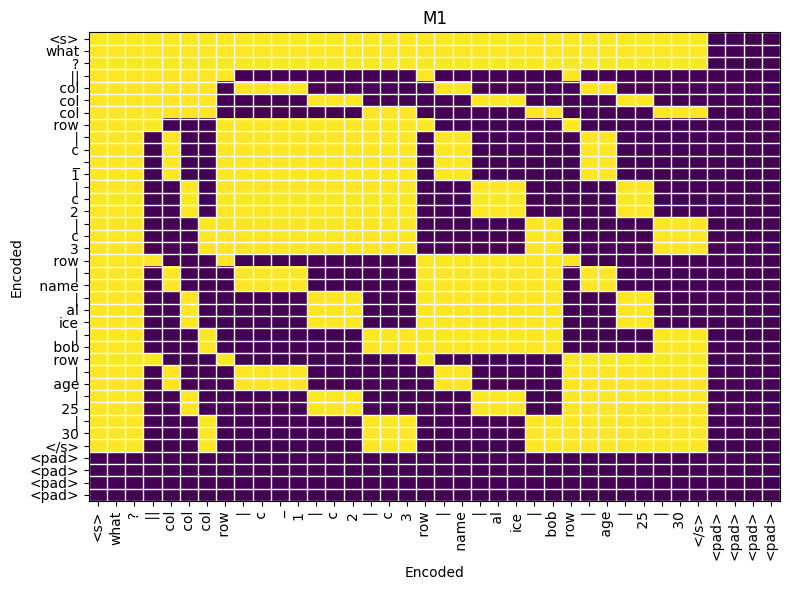

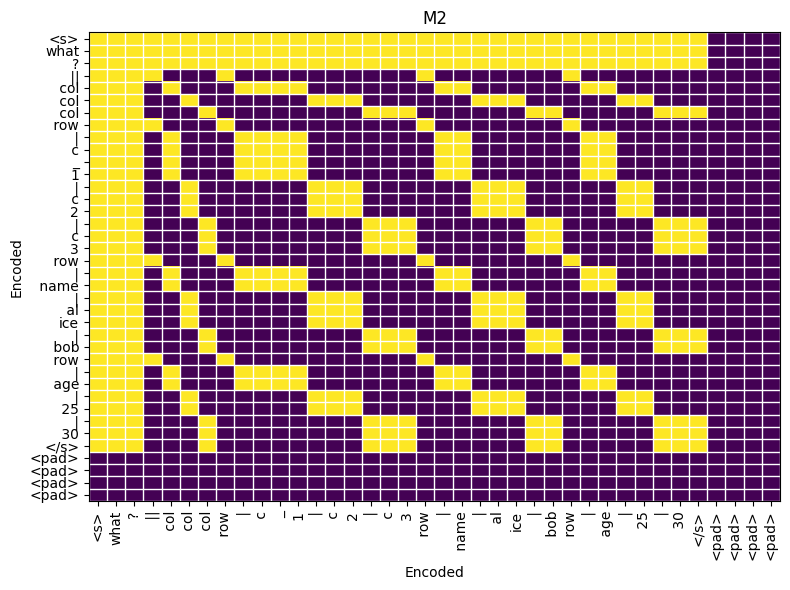

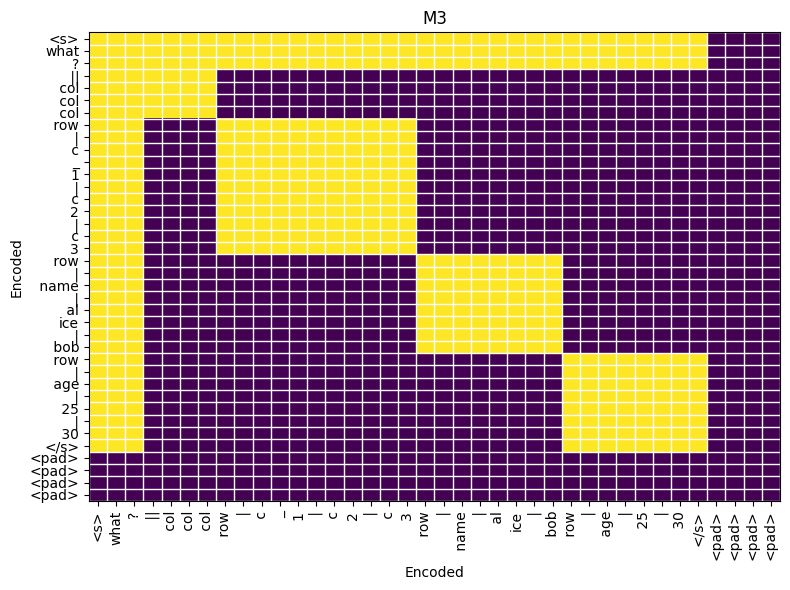

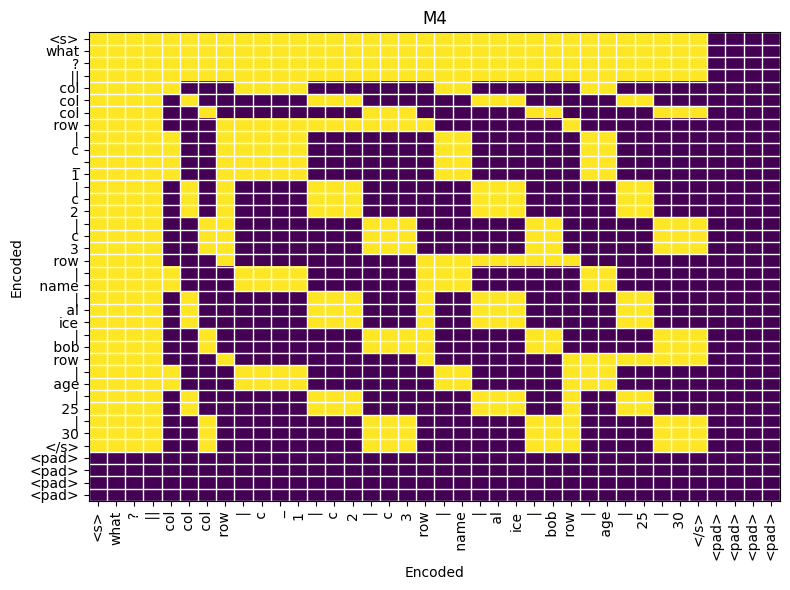

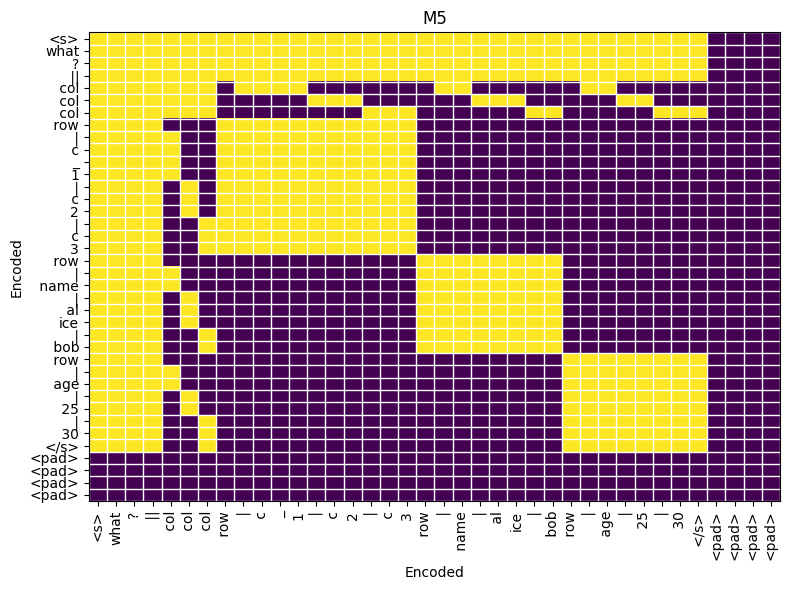

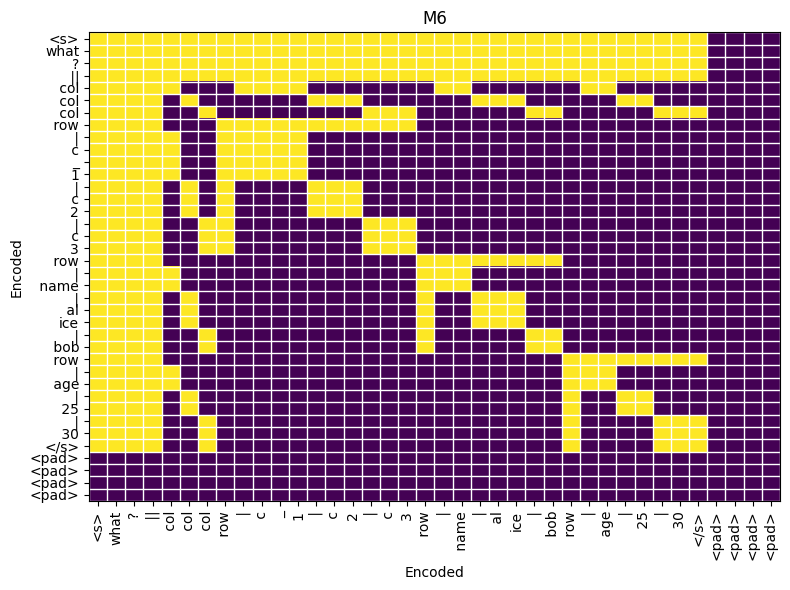

In [34]:
for mask_number in list(range(1,7)):
    mask = generate_mask(token_type, attention_mask, mask_number=mask_number)
    create_heatmap(mask, encoded, f"M{mask_number}", save= False)

## ➕ Bias Matrices for Structural Attention
Incorporate additive bias terms into attention scores based on relational structure, such as distance along rows or columns.\
These can be learned or fixed and help guide the attention mechanism toward semantically meaningful regions.\
🔍 Related Work: [TableFormer](https://arxiv.org/abs/2203.00274)

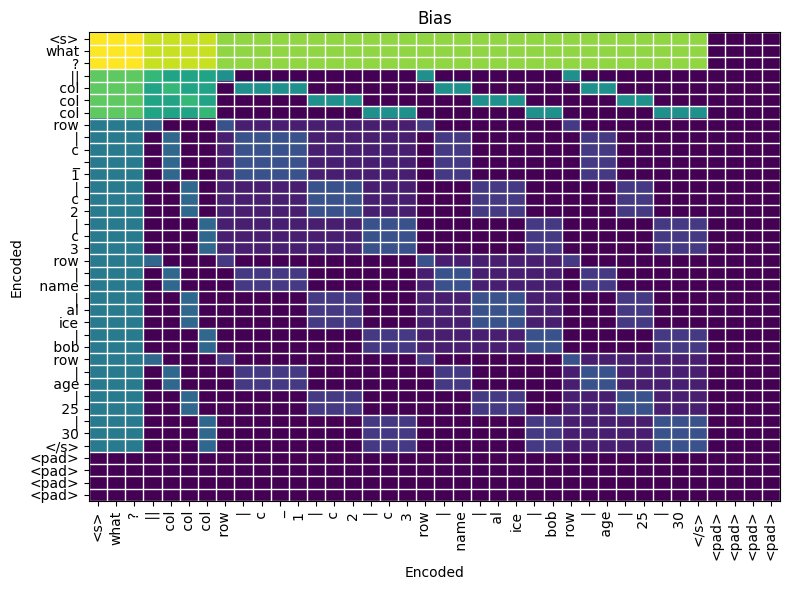

In [35]:
attention_mask_4d = _prepare_4d_attention_mask(attention_mask, torch.float32)
bias = get_relative_relation_ids(token_type, attention_mask_4d)
create_heatmap(bias, encoded, f"Bias",save= False)


## 🧱 Structural Embeddings: Row and Column IDs

Add trainable embeddings that encode structural roles such as row and column positions. \
These embeddings are combined with token embeddings to give the model awareness of each token’s structural location within the table.\
🔍 Related Work: [TAPAS](https://arxiv.org/pdf/2004.02349)

In [36]:
pd.DataFrame(token_type[0,:,[1,2]], columns=["columns_ids", "rows_ids"], index=encoded).T

,<s>,what,?,||,col,col,col,row,|,c,_,1,|,c,2,|,c,3,row,|,name,|,al,ice,|,bob,row,|,age,|,25,|,30,</s>,<pad>,<pad>,<pad>,<pad>
columns_ids,0,0,0,1,2,3,4,1,2,2,2,2,3,3,3,4,4,4,1,2,2,3,3,3,4,4,1,2,2,3,3,4,4,4,1,1,1,1
rows_ids,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,1,1,1,1


## 📏 Positional Encodings: TPE vs CPE
Use Cells Positional Encoding (CPE) or Table Positional Encoding (TPE) to represent the relative position of tokens and table elements.\
These encodings improve the model’s ability to generalize across varying table sizes and structures.

In [37]:
TPE = torch.arange(input_ids.shape[1], dtype=torch.long)
full_index = ProductIndexMap(IndexMap(token_type[:, :, 1], 256, batch_dims=1), IndexMap(token_type[:, :, 2], 256, batch_dims=1))
CPE = torch.min(
    torch.as_tensor(1024 - 1), TPE.unsqueeze(0) - gather(reduce_min(TPE, full_index)[0], full_index))


In [38]:
pd.DataFrame([CPE.squeeze().tolist(), TPE.tolist()],index=['CPE', 'TPE'], columns=encoded)

,<s>,what,?,||,col,col,col,row,|,c,_,1,|,c,2,|,c,3,row,|,name,|,al,ice,|,bob,row,|,age,|,25,|,30,</s>,<pad>,<pad>,<pad>,<pad>
CPE,0,1,2,0,0,0,0,0,0,1,2,3,0,1,2,0,1,2,0,0,1,0,1,2,0,1,0,0,1,0,1,0,1,2,27,28,29,30
TPE,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37


## ✅ Summary

This notebook outlines the architectural encoding mechanisms introduced in **TabStruct**.\
 These components serve as the building blocks of our model's and enable strong generalization to unseen table layouts.

Feel free to explore, modify inputs, and refer to our [paper](https://arxiv.org/pdf/2503.01457) and [GitHub repo](https://github.com/RaphaelMouravieff/TabStruct) for deeper details.